In [ ]:
! pip install timm pigeon-jupyter

# 1. Environment Set Up
- Do neccesary imports
- Set up where the data is 
- Create a Labeled Dataset

In [100]:
import torch, sys, os, numpy as np, pandas as pd
from tqdm import tqdm
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from fastai.vision.all import *
import timm

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

from skimage import io
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

from pigeon import annotate
from IPython import display

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from fastai.vision.all import *

In [101]:
! gdown "1XE_nUkrtiybUAm2c0yYO-lPJbYyFUcww"

Downloading...
From: https://drive.google.com/uc?id=1XE_nUkrtiybUAm2c0yYO-lPJbYyFUcww
To: /content/images.zip
100% 1.37G/1.37G [00:06<00:00, 207MB/s]


In [102]:
! unzip images.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/test/image3595.jpg  
  inflating: images/test/image3596.jpg  
  inflating: images/test/image3597.jpg  
  inflating: images/test/image3598.jpg  
  inflating: images/test/image3599.jpg  
  inflating: images/test/image36.jpg  
  inflating: images/test/image360.jpg  
  inflating: images/test/image3600.jpg  
  inflating: images/test/image3601.jpg  
  inflating: images/test/image3602.jpg  
  inflating: images/test/image3603.jpg  
  inflating: images/test/image3604.jpg  
  inflating: images/test/image3605.jpg  
  inflating: images/test/image3606.jpg  
  inflating: images/test/image3607.jpg  
  inflating: images/test/image3608.jpg  
  inflating: images/test/image3609.jpg  
  inflating: images/test/image361.jpg  
  inflating: images/test/image3610.jpg  
  inflating: images/test/image3611.jpg  
  inflating: images/test/image3612.jpg  
  inflating: images/test/image3613.jpg  
  inflating: images/test/image3614.jpg  
  inflatin

In [77]:
ROOT_DIR = "/content/images"

## 1(a) Create a Labeled Dataset

In [ ]:
annotations = annotate(
  [os.path.join(ROOT_DIR, "train", i) for  i in os.listdir(os.path.join(ROOT_DIR, "train"))],
  options=['military', 'non-military'],
  display_fn=lambda filename: display.display(display.Image(filename))
)

In [ ]:
labels_df = pd.DataFrame([(i[0].split("/")[-1], i[1]) for i in annotations], columns=[["filename", "label"]])

In [78]:
labels_df = pd.read_csv("/content/train_labels.csv", index_col=0)
# labels_df.to_csv("train_labels.csv")

# 2. Specify Additional Useful Functions (Utils)
- ArcFace Loss
- Transformation function to convert images to RGB

https://www.kaggle.com/code/slawekbiel/arcface-explained

In [79]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0, final_loss = FocalLossFlat()):
        super(ArcMarginProduct, self).__init__()
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.easy_margin = easy_margin
        self.final_loss = final_loss
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, cosine, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        sine = torch.sqrt(1.0 - torch.pow(cosine,2)).to(cosine.dtype) #needed for to_fp16()
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size(), device=CFG.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return self.final_loss(output, label)

In [80]:
def arcface_loss(cosine, targ, m=.4):
    # this prevents nan when a value slightly crosses 1.0 due to numerical error
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    # Step 3:
    arcosine = cosine.arccos()
    # Step 4:
    one_hot = torch.zeros(cosine.size(), device='cuda')
    one_hot.scatter_(1, targ.view(-1, 1).long(), 1)
    arcosine += one_hot * m
    # Step 5:
    cosine2 = arcosine.cos()
    # Step 6:
    return FocalLossFlat()(cosine2, targ)

In [81]:
class CosineClassifier(nn.Module):
    def __init__(self, emb_size, output_classes):
        super(CosineClassifier, self).__init__()
        self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        # Step 1:
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        # Step 2:
        return x_norm @ W_norm

In [82]:
def convert_to_color(img: PILImage):
    np_img = np.array(img)
    if np_img.ndim <3:
        np_img = np.repeat(np_img[:, :, np.newaxis], 3, axis=2)
    return PILImage.create(np_img)

# 2. Set Up Configuration

In [84]:
class CFG:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Data
    batch_size= 16
    img_size = 384
    shuffle=True
    label_col = "label"
    fn_col = "filename"
    data_path = os.path.join(ROOT_DIR, "train")
    
    # Model
    model_name = 'resnext101_64x4d'
    model_dir = "fastai_models"
    pretrained = True
    num_classes=2
    
    # Training
    epochs = 15
    freeze_epochs=3
    loss_func = BaseLoss(ArcMarginProduct)
    callbacks = [
        EarlyStoppingCallback(monitor="valid_loss", min_delta=0.001, patience=3)
    ]
    metrics = [
        accuracy_multi, F1ScoreMulti
    ]
    num_folds = 4

# 3. Create Data Loaders
- create and check any custom transforms
- specify image augmentation
- add in any validation splits

In [85]:
train, val = train_test_split(labels_df)
train["valid"] = 0
val["valid"] = 1
labels_df = pd.concat([train, val])

In [86]:
dls = ImageDataLoaders.from_df(labels_df, num_workers=0,
                                   label_col= CFG.label_col,
                                   fn_col = CFG.fn_col,
                                   path = CFG.data_path,
                                   bs = CFG.batch_size,
                                   valid_col = "valid",
                                   shuffle = CFG.shuffle,
                                   device = CFG.device,
                                   item_tfms=[convert_to_color, Resize(460)],
                                   batch_tfms=aug_transforms(size=CFG.img_size)
                                  )

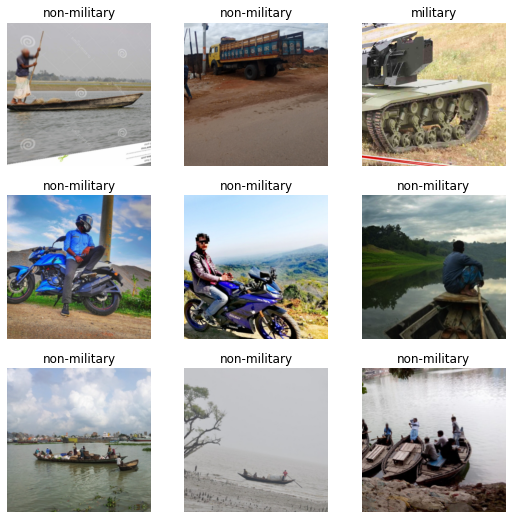

In [87]:
dls.show_batch()

# 4. Train the Model
- Create the model
- Create a FastAI Learner
- Find a good learning rate for model
- Fit a model across different folds of the data


In [88]:
class NN_Model(nn.Module):

    def __init__(self,
                 n_classes,
                 model_name=CFG.model_name,
                 pretrained=True):
        
        super(NN_Model, self).__init__()

        model = timm.create_model(model_name, pretrained=pretrained)
        final_in_features = list(model.children())[-1].in_features
        self.backbone = nn.Sequential(*list(model.children())[:-1])
        self.classifier = CosineClassifier(final_in_features, n_classes)
        #self.classifier = nn.Linear(final_in_features, n_classes, bias = True)


    def forward(self, x):
        feature = self.backbone(x)
        return self.classifier(feature)


In [89]:
model = NN_Model(CFG.num_classes, model_name=CFG.model_name, pretrained=CFG.pretrained).to(CFG.device)
learn = Learner(dls, model, loss_func=CFG.loss_func, metrics=accuracy, cbs = CFG.callbacks,
                path=CFG.model_path, model_dir=CFG.model_dir).to_fp16()

AttributeError: ignored

SuggestedLRs(valley=0.009120108559727669)

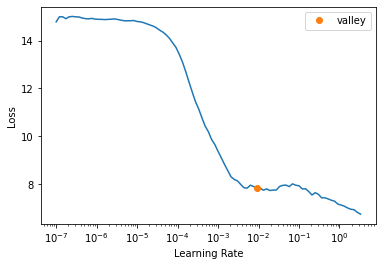

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(epochs=CFG.epochs, base_lr=1e-3, freeze_epochs=CFG.freeze_epochs, 
                    cbs=[SaveModelCallback(monitor="valid_loss", min_delta=0.001, fname=CFG.model_name+"_trained")])


epoch,train_loss,valid_loss,accuracy,time
0,13.406668,3.846921,0.980769,00:10
1,6.774623,1.664328,0.942308,00:10
2,4.840068,16.596073,0.384615,00:10


Better model found at epoch 0 with valid_loss value: 3.846920967102051.
Better model found at epoch 1 with valid_loss value: 1.6643283367156982.


epoch,train_loss,valid_loss,accuracy,time
0,2.096617,1.100604,0.961538,00:10
1,1.354269,0.593627,0.980769,00:10
2,1.131688,2.760634,0.961538,00:10
3,0.892721,0.325903,1.000000,00:10
4,0.806445,2.938899,0.942308,00:10
5,1.454562,3.457133,0.903846,00:10
6,1.335084,5.605674,0.807692,00:10


Better model found at epoch 0 with valid_loss value: 1.1006041765213013.
Better model found at epoch 1 with valid_loss value: 0.5936265587806702.
Better model found at epoch 3 with valid_loss value: 0.3259029984474182.
No improvement since epoch 3: early stopping


### Check out predictions and losses

In [ ]:
learn.load(os.path.join(CFG.model_name+"_trained"))

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


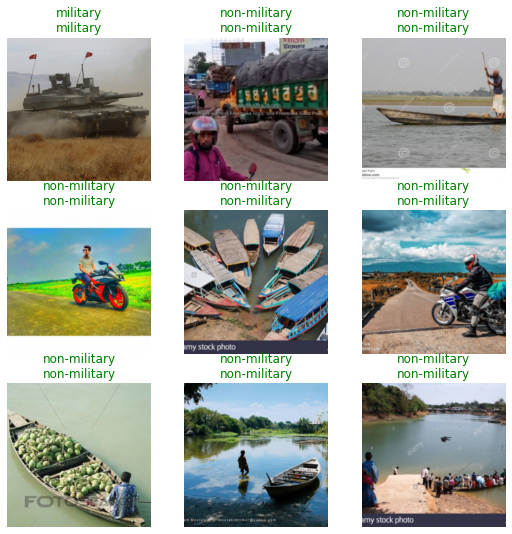

In [ ]:
learn.loss_func = FocalLossFlat()
learn.show_results()

In [ ]:
interp = Interpretation.from_learner(learn)

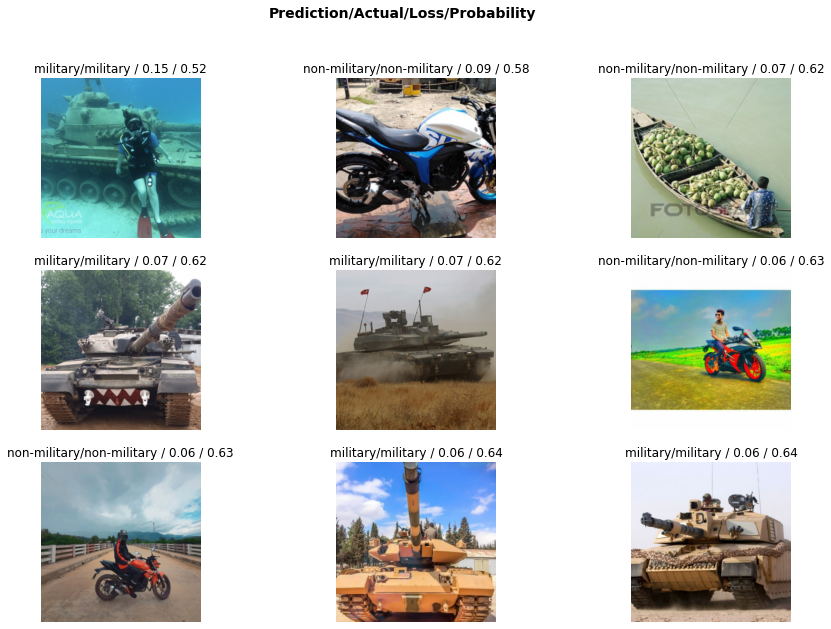

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

# 5. Perform Inference
- Need to have the DataLoader and model already defined.

In [103]:
img_files = [os.path.join(ROOT_DIR, "test", i) for  i in os.listdir(os.path.join(ROOT_DIR, "test"))][:1000]
test_dl = learn.dls.test_dl(img_files)

In [104]:
preds, _ = learn.get_preds(dl=test_dl)

In [105]:
preds = preds.to('cpu').numpy().argmax(axis=1)

In [106]:
def plot_image_grid(images, ncols=None, cmap='gray'):
    '''Plot a grid of images'''
    if not ncols:
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
    nrows = int(len(images) / ncols) + int(len(images) % ncols)
    imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    for img, ax in zip(imgs, axes.flatten()): 
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.imshow(img, cmap=cmap)

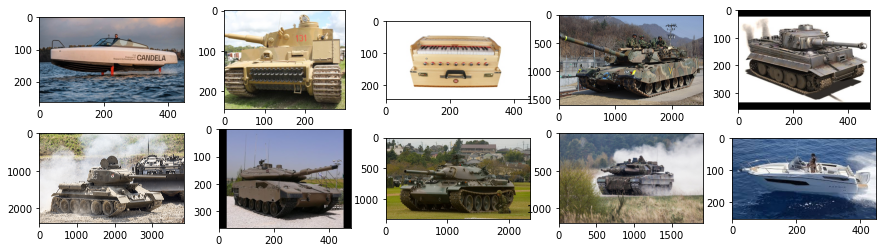

In [107]:
mil_images = [mpimg.imread(img_files[i]) for i in np.where(preds==0)[0]][:10]

plot_image_grid(mil_images)

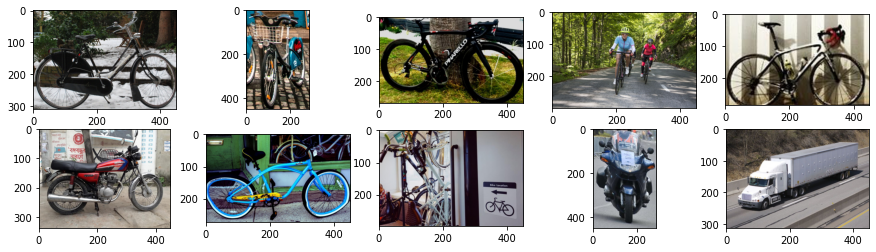

In [108]:
civ_images = [mpimg.imread(img_files[i]) for i in np.where(preds==1)[0]][:10]

plot_image_grid(civ_images)